In [1]:
import numpy as np
import mne
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pathlib
import pandas as pd
import scipy as sp
from tqdm.notebook import tqdm 
from collections import Counter
from collections import OrderedDict
import statsmodels.formula.api as smf
import xarray as xr
import statsmodels.api as sm
from mne import create_info
from mne.io import RawArray
from mne.viz.topomap import _add_colorbar
from mne.viz import plot_topomap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from statsmodels.stats.anova import AnovaRM
import warnings
from scipy.stats import shapiro
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
import numpy as np
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Load Datasets

In [2]:
# Import the data
eeg_wide = pd.read_csv("C:/Users/gabot/OneDrive - McGill University/Desktop/Lateralization_infants_P/datasets/outputs/april_2025_lat_values_wide.csv")
eeg_long = pd.read_csv("C:/Users/gabot/OneDrive - McGill University/Desktop/Lateralization_infants_P/datasets/outputs/april_2025_lat_values_melt.csv")
demo_df = pd.read_csv("C:/Users/gabot/OneDrive - McGill University/Desktop/Lateralization_infants_P/datasets/demographics/demographics_eegip_2024.csv")
regions_df = pd.read_csv("C:/Users/gabot/OneDrive - McGill University/Desktop/Lateralization_infants_P/datasets/outputs/2025_04_11_WANG_specific_regions.csv")
all_freq_df = pd.read_csv("C:/Users/gabot/OneDrive - McGill University/Desktop/Lateralization_infants_P/datasets/outputs/april_2025_all_frequencies.csv")
# Subset by band
#band = "gamma"

# Drop rows with nan values in band 
eeg_long = eeg_long[eeg_long.band.isna() == False]

## Drop participants with unknown outcome
eeg_long = eeg_long[eeg_long.outcome.isna() == False]
eeg_long.network.unique()


array(['DMN', 'all_regions', 'attn', 'auditory', 'lang', 'visual'],
      dtype=object)

In [3]:
# Select participants with known outcome in a list 
final_participants = eeg_long[eeg_long.outcome.isna() == False].subject.unique()

# Subset all frequency dataframe to only include participants with known outcome
all_freq_df = all_freq_df[all_freq_df.subject.isin(final_participants)]

In [4]:
all_freq_df.region1.unique()

array(['bankssts-rh', 'caudalanteriorcingulate-rh',
       'caudalmiddlefrontal-rh', 'cuneus-rh', 'frontalpole-rh',
       'fusiform-rh', 'inferiorparietal-rh', 'inferiortemporal-rh',
       'insula-rh', 'isthmuscingulate-rh', 'lateraloccipital-rh',
       'lateralorbitofrontal-rh', 'lingual-rh', 'medialorbitofrontal-rh',
       'middletemporal-rh', 'paracentral-rh', 'parahippocampal-rh',
       'parsopercularis-rh', 'parsorbitalis-rh', 'parstriangularis-rh',
       'pericalcarine-rh', 'postcentral-rh', 'posteriorcingulate-rh',
       'precentral-rh', 'precuneus-rh', 'rostralanteriorcingulate-rh',
       'rostralmiddlefrontal-rh', 'superiorfrontal-rh',
       'superiorparietal-rh', 'superiortemporal-rh', 'supramarginal-rh',
       'temporalpole-rh', 'transversetemporal-rh'], dtype=object)

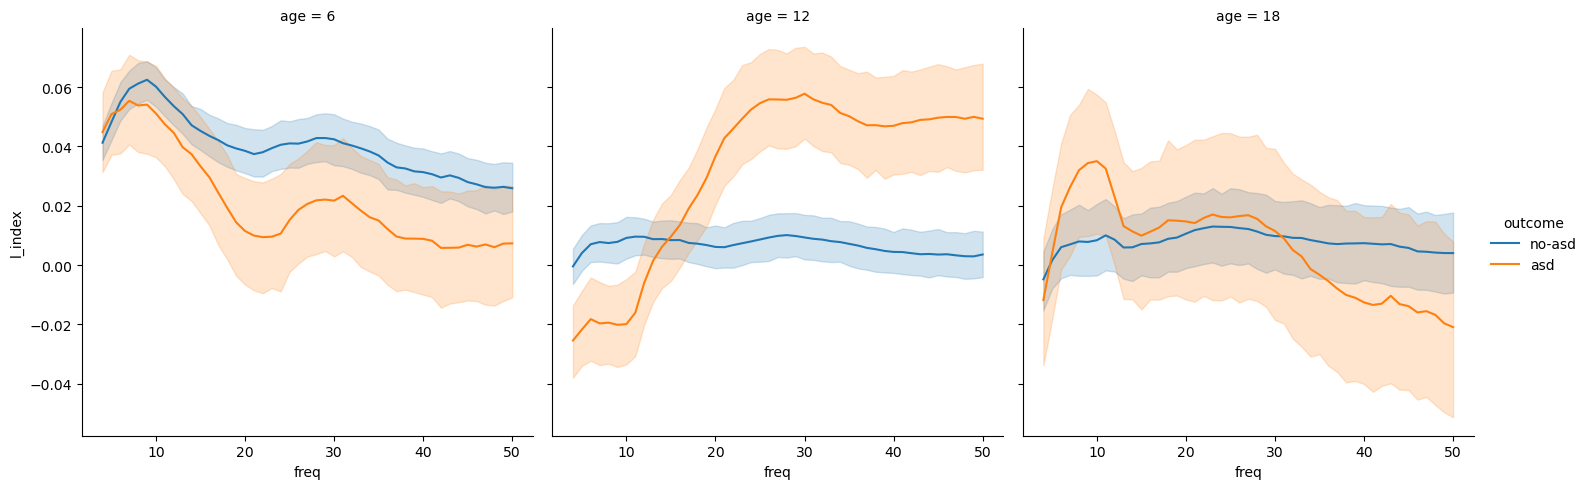

In [6]:
sns.relplot(col="age", y="l_index", hue="outcome", x="freq",
            data=all_freq_df, kind="line")

### Figure settings on matplot_lib

In [5]:
## Code in one cell
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#fig.savefig("./paper_1_figs/figure_1_lateralization_3.png" ,bbox_inches="tight", dpi=300)

## FIGURE 1 RISK VS TL

In [7]:
fig = plt.figure(figsize=(5, 8), facecolor='white') #constrained_layout=False, 
gs1 = gridspec.GridSpec(2, 2, wspace=0)        
ax11 = fig.add_subplot(gs1[0, 0])

ax11.xaxis.set_visible(False)   
ax12 = fig.add_subplot(gs1[0, 1], sharex=ax11, sharey=ax11)
ax12.xaxis.set_visible(False)   
ax12.yaxis.set_visible(False)   
ax13 = fig.add_subplot(gs1[1, 0],sharex=ax11,sharey=ax11)
ax14 = fig.add_subplot(gs1[1, 1],sharex=ax11,sharey=ax11)
ax14.yaxis.set_visible(False)   
 
gs1.tight_layout(fig, rect=[0, 0.6, 1, 1.03], w_pad=0.0, h_pad=1.2)

gs3 = gridspec.GridSpec(1, 2)        
ax31 = fig.add_subplot(gs3[0, 0])
ax32 = fig.add_subplot(gs3[0, 1],sharex=ax31,sharey=ax31)
ax32.yaxis.set_visible(False)   
gs3.tight_layout(fig, rect=[0, 0.16, 1, 0.46], w_pad=0.0, h_pad=-0.5)

gs4 = gridspec.GridSpec(1, 2)        
ax41 = fig.add_subplot(gs4[0, 0])
ax42 = fig.add_subplot(gs4[0, 1],sharex=ax41,sharey=ax41)
gs4.tight_layout(fig, rect=[0, -0.16, 1.0, 0.106], w_pad=0.0, h_pad=-0.5)
ax42.yaxis.set_visible(False)  
fig.text(-0.055, 1.03, "A", size=25, ha="center", transform=fig.transFigure)
fig.text(-0.055, 0.47, "B", size=25, ha="center", transform=fig.transFigure)
fig.text(-0.055, 0.13, "C", size=25, ha="center", transform=fig.transFigure)

df_name=eeg_long
df_name=df_name[~df_name.band.isna()]
df_name= df_name.loc[df_name.age<18]
df_name= df_name.loc[df_name.network=="all_regions"]
df_name.group_type= df_name.group_type.str.replace('ELA', 'EL', regex=True)
df_name.group_type= df_name.group_type.str.replace('TLA', 'TL', regex=True)
for ax, band in zip([ax11, ax12, ax13, ax14], ["Theta", "Alpha", "Beta","Gamma"]):
    sns.pointplot(x="age",y="l_index", hue="group_type",palette=["goldenrod","purple"],
                     data=df_name[df_name.band ==band.lower()],dodge=0.1, ax=ax)
    ax.set_title(band, fontsize=15)
    ax.axhline(0,  linestyle='--', color="black")
    if band =="Gamma":
        
        ax.legend(bbox_to_anchor=(-0.55, -0.83), loc="lower left", borderaxespad=0., ncol=2.)
    else:
        ax.legend_.set_visible(False)            
ax11.set(ylabel="", xlabel="")
ax13.set(xlabel="")
ax13.set(ylabel="")
ax14.set(xlabel="")
"""ax13.set(xlabel="Age (months)")
ax13.set(ylabel="Lateralization index")
ax14.set(xlabel="Age (months)")"""
#ax11.legend("")
fig.text(0.4, 0.595, 'Age (months)', ha='left')
fig.text(-0.055, 0.82, 'Lateralization index', va='center', rotation='vertical')

graph_2_data = all_freq_df.groupby(["subject","group_type", "site","age","freq"]).mean().reset_index()
graph_2_data = graph_2_data.loc[graph_2_data.age!=18]
graph_2_data
both_sites= graph_2_data
both_sites["site"]="Combined"
graph_2_data = all_freq_df.groupby(["subject","group_type", "site","age","freq"]).mean().reset_index()
graph_2_data = graph_2_data.loc[graph_2_data.age!=18]
both_sites=pd.concat([graph_2_data,both_sites])
df_name=graph_2_data.copy()
df_name.group_type= df_name.group_type.str.replace('ELA', 'EL', regex=True)
df_name.group_type= df_name.group_type.str.replace('TLA', 'TL', regex=True)

for ax, age_n in zip([ax31, ax32], [6,12]):
    df2 = df_name.copy().loc[df_name.age==age_n]
    sns.lineplot(x="freq",y="l_index",hue="group_type", 
              palette=["goldenrod","purple"],
              data=df2, ci=90,ax=ax )
    ax.axhline(0,  linestyle='--', color="black")
    ax.set_title(f"{age_n} months", fontsize=15)
    ax.legend_.set_visible(False)            
ax31.set(ylabel="Lateralization Index")
ax32.set(ylabel="")
ax31.set(xlabel="")
ax32.set(xlabel="")
fig.text(0.4, 0.145, 'Frequency (Hz)', ha='left')

df_name= eeg_long[(eeg_long.age!=18)].copy()
df_name= df_name.loc[df_name.band!="broadband"]
df_name["Band"]= df_name["band"]

df_name.group_type= df_name.group_type.str.replace('ELA', 'EL', regex=True)
df_name.group_type= df_name.group_type.str.replace('TLA', 'TL', regex=True)
df_name= df_name[(df_name.network=="all_regions")]
df_name.Band = df_name.Band.str.capitalize()


for ax, group in zip([ax41, ax42], ["EL", "TL"]):
    df2 = df_name.copy().loc[df_name.group_type==group]
    sns.pointplot(x="age",y="l_index",hue="Band",
                  palette=["brown","purple", "lightcoral", "goldenrod"],
                    data=df2, ci=90,ax=ax ,dodge=0.1 )
    ax.set_title(group, fontsize=15)   
    ax.axhline(0,  linestyle='--', color="black")
    if group=="EL":
         ax.legend(bbox_to_anchor=(-0.35, -0.45), 
                 loc="upper left", borderaxespad=0., ncol=4)
    else:
        ax.legend_.set_visible(False) 
ax41.set(ylabel="Lateralization index")
ax42.set(ylabel="")
ax41.set(xlabel="")
ax42.set(xlabel="")
fig.text(0.4, -0.165, 'Age (months)', ha='left')
fig.subplots_adjust(bottom=-0.3, top=1.3, left=-0.1, right=1)

fig.savefig("../figures/Figure_1_2025_03_27.png"  ,bbox_inches="tight",dpi=300)

C:\Users\gabot\AppData\Local\Temp\ipykernel_22784\3252687489.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs3.tight_layout(fig, rect=[0, 0.16, 1, 0.46], w_pad=0.0, h_pad=-0.5)
C:\Users\gabot\AppData\Local\Temp\ipykernel_22784\3252687489.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs4.tight_layout(fig, rect=[0, -0.16, 1.0, 0.106], w_pad=0.0, h_pad=-0.5)
C:\Users\gabot\AppData\Local\Temp\ipykernel_22784\3252687489.py:57: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  graph_2_data = all_freq_df.groupby(["subject","group_type", "site","age","freq"]).mean().reset_index()
C:\Users\gabot\AppData\Local\Temp\ipykernel_22784\3252687489.py:62: FutureWarnin

## FIGURE 2 ASD VS NON_ASD

In [8]:
fig = plt.figure(figsize=(7, 7), facecolor='white') #constrained_layout=False, 
gs1 = gridspec.GridSpec(2, 2, wspace=0)        
ax11 = fig.add_subplot(gs1[0, 0])

ax11.xaxis.set_visible(False)   
ax12 = fig.add_subplot(gs1[0, 1], sharex=ax11, sharey=ax11)
ax12.xaxis.set_visible(False)   
ax12.yaxis.set_visible(False)   


ax13 = fig.add_subplot(gs1[1, 0],sharex=ax11,sharey=ax11)
ax14 = fig.add_subplot(gs1[1, 1],sharex=ax11,sharey=ax11)
ax14.yaxis.set_visible(False)   

  
gs1.tight_layout(fig, rect=[0, 0.56, 0.6, 1.02], w_pad=0.0, h_pad=1.2)

gs2 = gridspec.GridSpec(2, 1)        
ax21 = fig.add_subplot(gs2[0, 0])
ax22 = fig.add_subplot(gs2[1,0],sharex=ax21,sharey=ax21)
ax21.xaxis.set_visible(False)   

gs2.tight_layout(fig, rect=[0.65, 0.5, 1.0, 1.02], w_pad=0.0, h_pad=1.5)
gs3 = gridspec.GridSpec(1, 3)        
ax31 = fig.add_subplot(gs3[0, 0])
ax32 = fig.add_subplot(gs3[0, 1],sharex=ax31,sharey=ax31)
ax33 = fig.add_subplot(gs3[0, 2],sharex=ax31,sharey=ax31)
ax32.yaxis.set_visible(False)   
ax33.yaxis.set_visible(False)  
gs3.tight_layout(fig, rect=[0, 0.185, 1.0, 0.46], w_pad=0.0, h_pad=-0.5)

gs4 = gridspec.GridSpec(1, 2)        
ax41 = fig.add_subplot(gs4[0, 0])
ax42 = fig.add_subplot(gs4[0, 1],sharex=ax41,sharey=ax41)
gs4.tight_layout(fig, rect=[0.15, -0.17, 0.85, 0.16], w_pad=0.0, h_pad=-0.2)

ax42.yaxis.set_visible(False)  
ax42.yaxis.set_visible(False)

fig.text(-0.055, 1.03, "A", size=BIGGER_SIZE, ha="center", transform=fig.transFigure)
fig.text(0.65, 1.03, "B", size=BIGGER_SIZE, ha="center", transform=fig.transFigure)
fig.text(-0.055, 0.45, "C", size=BIGGER_SIZE, ha="center", transform=fig.transFigure)
fig.text(-0.055, 0.16, "D", size=BIGGER_SIZE, ha="center", transform=fig.transFigure)

legend = plt.legend()
legend.get_frame().set_facecolor('none')

df_name=eeg_long
df_name=df_name[~df_name.band.isna()]
df_name= df_name.loc[df_name.age<18]
df_name= df_name.loc[df_name.network=="all_regions"]
df_name.outcome= df_name.outcome.str.replace('asd', 'ASD', regex=True)
df_name.outcome= df_name.outcome.str.replace('control', 'no-ASD', regex=True)
df_name=df_name.sort_values("outcome")

for ax, band in zip([ax11, ax12, ax13, ax14], ["Theta", "Alpha", "Beta","Gamma"]):
    sns.pointplot(x="age",y="l_index", hue="outcome",palette=["goldenrod","purple"],
                     data=df_name[df_name.band ==band.lower()],dodge=0.1, ax=ax)
    ax.set_title(band)
    ax.axhline(0,  linestyle='--', color="black")
    if band =="Beta":
        
        ax.legend(bbox_to_anchor=(0.28, -0.72), loc="lower left", borderaxespad=0., ncol=3)
    else:
        ax.legend_.set_visible(False)            
ax11.set(ylabel="", xlabel="")
ax13.set(xlabel="")
ax13.set(ylabel="")
ax14.set(xlabel="")
fig.text(0.23, 0.56, 'Age (months)', ha='left')
fig.text(-0.055, 0.8, 'Lateralization index', va='center', rotation='vertical')

graph_2_data = all_freq_df.groupby(["subject","outcome", "site","age","freq"]).mean().reset_index()
graph_2_data = graph_2_data.loc[graph_2_data.age!=18]
graph_2_data
both_sites= graph_2_data
both_sites["site"]="Combined"
graph_2_data = all_freq_df.groupby(["subject","outcome", "site","age","freq"]).mean().reset_index()
graph_2_data = graph_2_data.loc[graph_2_data.age!=18]
both_sites=pd.concat([graph_2_data,both_sites])
df_name=graph_2_data.copy()
df_name.outcome= df_name.outcome.str.replace('asd', 'ASD', regex=True)
df_name.outcome= df_name.outcome.str.replace('control', 'no-ASD', regex=True)
df_name=df_name.sort_values("outcome")
for ax, age_n in zip([ax21, ax22], [6,12]):
    df2 = df_name.copy().loc[df_name.age==age_n]
    sns.lineplot(x="freq",y="l_index",hue="outcome", 
              palette=["goldenrod","purple"],
              data=df2, ci=90,ax=ax )
    ax.axhline(0,  linestyle='--', color="black")
    ax.set_title(f"{age_n} months")
    ax.legend_.set_visible(False)   
    ax.set_xlim(all_freq_df.freq.unique()[[0,-1]])
ax21.set(ylabel="")
ax22.set(ylabel="")
ax22.set(xlabel="Frequency (Hz)")
fig.text(0.62, 0.75, 'Lateralization index', va='center', 
         rotation='vertical')
df_name=both_sites
df_name.outcome= df_name.outcome.str.replace('asd', 'ASD', regex=True)
df_name.outcome= df_name.outcome.str.replace('non-asd', 'no-ASD', regex=True)
df_name=df_name[df_name.age != 6]
df_name.site= df_name.site.str.replace('washington', 'Seattle', regex=True)
df_name.site= df_name.site.str.replace('london', 'London', regex=True)
df_name=df_name.sort_values("outcome")
for ax, place in zip([ax31, ax32, ax33], ["Seattle", "London","Combined"]):
    df2 = df_name.copy().loc[df_name.site==place]
    if place =="London":
        
        sns.lineplot(x="freq",y="l_index",hue="outcome", 
              palette=["goldenrod","purple"],
              data=df2, ci=90,ax=ax )
    
    else:
          sns.lineplot(x="freq",y="l_index",hue="outcome", 
              palette=["goldenrod","purple"],
              data=df2, ci=90,ax=ax )      
    ax.legend_.set_visible(False)  
    ax.set_title(place)   
    ax.set_xlim(all_freq_df.freq.unique()[[0,-1]])
    ax.axhline(0,  linestyle='--', color="black")
ax31.set(ylabel="Lateralization index")
ax32.set(ylabel="")
ax33.set(ylabel="")
ax31.set(xlabel="")
ax32.set(xlabel="Frequency (Hz)")
ax33.set(xlabel="")

eeg_long3= eeg_long[(eeg_long.age!=18)]
df_name= eeg_long3
df_name= df_name.loc[df_name.band!="broadband"]
df_name["Band"]= df_name["band"]
df_name.Band = df_name.Band.str.capitalize()
df_name.outcome= df_name.outcome.str.replace('asd', 'ASD', regex=True)
df_name.outcome= df_name.outcome.str.replace('control', 'no-ASD', regex=True)
df_name= df_name[(df_name.network=="all_regions")]
df_name=df_name.sort_values("outcome")
for ax, group in zip([ax41, ax42], ["ASD", "no-ASD"]):
    df2 = df_name.copy().loc[df_name.outcome==group]
    sns.pointplot(x="age",y="l_index",hue="Band", 
                palette=["brown","purple", "lightcoral", "goldenrod"],

                    data=df2, ci=90,ax=ax ,dodge=0.1 )
    ax.set_title(group)   
    ax.axhline(0,  linestyle='--', color="black")
    if group=="ASD":
 
        ax.legend(bbox_to_anchor=(-0.32, -0.35), 
                 loc="upper left", borderaxespad=0., ncol=4)
    else:
        ax.legend_.set_visible(False) 
ax41.set(ylabel="Lateralization index")
ax42.set(ylabel="")
ax41.set(xlabel="")
ax42.set(xlabel="")

fig.text(0.44, -0.175, 'Age (months)', ha='left')

#fig.savefig("./thesisv1_figure_1_lateralization_3.png"  ,bbox_inches="tight",dpi=300)
fig.savefig("../figures/Figure_2_2025_03_27.png"  ,bbox_inches="tight",dpi=300)

C:\Users\gabot\AppData\Local\Temp\ipykernel_22784\1743236194.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs2.tight_layout(fig, rect=[0.65, 0.5, 1.0, 1.02], w_pad=0.0, h_pad=1.5)
C:\Users\gabot\AppData\Local\Temp\ipykernel_22784\1743236194.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs3.tight_layout(fig, rect=[0, 0.185, 1.0, 0.46], w_pad=0.0, h_pad=-0.5)
C:\Users\gabot\AppData\Local\Temp\ipykernel_22784\1743236194.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs4.tight_layout(fig, rect=[0.15, -0.17, 0.85, 0.16], w_pad=0.0, h_pad=-0.2)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\gabot\AppData\Local\Temp\ipykernel_22784\1743236194.py:73: Fut

## FIGURE 4 REGIONS

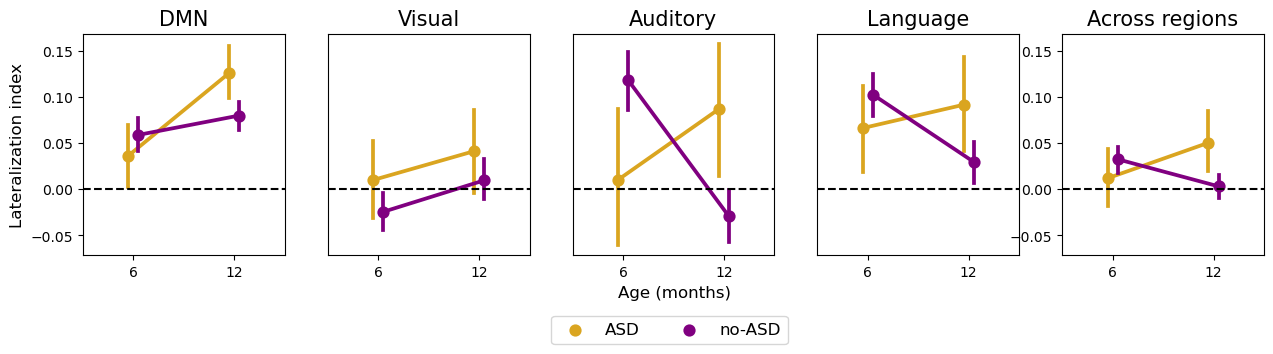

In [8]:
fig = plt.figure(figsize=(9, 7), facecolor='white') #constrained_layout=False, 
gs1 = gridspec.GridSpec(1, 5)        
ax51 = fig.add_subplot(gs1[0, 0])
ax52 = fig.add_subplot(gs1[0, 1],sharex=ax51,sharey=ax51)
ax53 = fig.add_subplot(gs1[0, 2],sharex=ax51,sharey=ax51)
ax54 = fig.add_subplot(gs1[0, 3],sharex=ax51,sharey=ax51)
ax55 = fig.add_subplot(gs1[0, 4],sharex=ax51,sharey=ax51)

gs1.tight_layout(fig, rect=[0, 0.6, 1.4, 1.01], w_pad=0.0, h_pad=-0.5)
ax52.yaxis.set_visible(False)   
ax53.yaxis.set_visible(False) 
ax54.yaxis.set_visible(False) 

eeg_long2=eeg_long.copy()
eeg_long2=eeg_long2.sort_values("site")

eeg_long2= eeg_long[(eeg_long.age!=18)]
eeg_long2= eeg_long2[(eeg_long2.band=="gamma")]
#eeg_long2= eeg_long2.loc[(eeg_long2.network!="all_regions")]
eeg_long2= eeg_long2.loc[(eeg_long2.network!="attn")]


df_name=eeg_long2
df_name.outcome= df_name.outcome.str.replace('control', 'Non-ASD', regex=True)
df_name.outcome= df_name.outcome.str.replace('asd', 'ASD', regex=True)
df_name.network= df_name.network.str.replace('all_regions', 'Across regions', regex=True)
df_name.network= df_name.network.str.replace('DMN', 'DMN', regex=True)
df_name.network= df_name.network.str.replace('auditory', 'Auditory', regex=True)
df_name.network= df_name.network.str.replace('lang', 'Language', regex=True)
df_name.network= df_name.network.str.replace('visual', 'Visual', regex=True)

df_name=df_name.sort_values("outcome")
regions_order=['DMN',"Visual",'Auditory',"Language" ,'Across regions']
for ax, region in zip([ax51, ax52, ax53, ax54, ax55],regions_order):
    df2 = df_name.copy().loc[df_name.network==region]
    sns.pointplot(x="age",y="l_index",hue="outcome", 
                    data=df2, ci=90,ax=ax ,dodge=0.1,palette=[ "goldenrod", "purple"] )
    ax.set_title(region)   
    ax.axhline(0,  linestyle='--', color="black")
    if region=="DMN":
        ax.legend(bbox_to_anchor=(2.32, -0.4), 
                 loc="lower left", borderaxespad=0., ncol=4)
        ax.set(ylabel="Lateralization index")
        ax.set(xlabel="")
    else:
        ax.legend_.set_visible(False)
        ax.set(ylabel="")
        ax.set(xlabel="")
fig.text(0.65, 0.6, 'Age (months)', ha='left')
plt.show()

# SAve
fig.savefig("../figures/Figure_3_2025_04_11_WANG_specific_regions.png"  ,bbox_inches="tight",dpi=300)

In [7]:
fig.subplots_adjust(bottom=-0.3, top=1.3, left=-0.1, right=1)
fig.savefig("./Figure_3_2025_04_11_WANG_specific_regions.png" ,bbox_inches="tight", dpi=300)

## Supp Figure 1

In [ ]:
eeg_long2=eegip_lat_melt.copy()

In [ ]:
eeg_long2

,subject,outcome,network,age,freq,group_type,gender,site,l_index,band
0,2,HRA-,all_regions,6,5.0,HRA,M,washington,0.318535,theta
1,2,HRA-,all_regions,6,9.5,HRA,M,washington,0.368947,alpha
2,2,HRA-,all_regions,6,21.5,HRA,M,washington,0.280324,beta
3,2,HRA-,all_regions,6,27.0,HRA,M,washington,0.321517,NaN
4,2,HRA-,all_regions,6,40.0,HRA,M,washington,0.252155,gamma
...,...,...,...,...,...,...,...,...,...,...
10735,937,control,parsorbital,18,5.0,LRC,M,washington,0.261134,theta
10736,937,control,parsorbital,18,9.5,LRC,M,washington,0.300971,alpha
10737,937,control,parsorbital,18,21.5,LRC,M,washington,0.248917,beta
10738,937,control,parsorbital,18,27.0,LRC,M,washington,0.254823,NaN


C:\Users\gabot\AppData\Local\Temp\ipykernel_16116\2590864875.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs2.tight_layout(fig, rect=[0.65, 0.5, 1.0, 1.02], w_pad=0.0, h_pad=1.5)
C:\Users\gabot\AppData\Local\Temp\ipykernel_16116\2590864875.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs3.tight_layout(fig, rect=[0, 0.185, 1.0, 0.46], w_pad=0.0, h_pad=-0.5)
C:\Users\gabot\AppData\Local\Temp\ipykernel_16116\2590864875.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs4.tight_layout(fig, rect=[0, -0.2, 1.0, 0.15], w_pad=0.0, h_pad=-0.5)
C:\Users\gabot\AppData\Local\Temp\ipykernel_16116\2590864875.py:79: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify nume

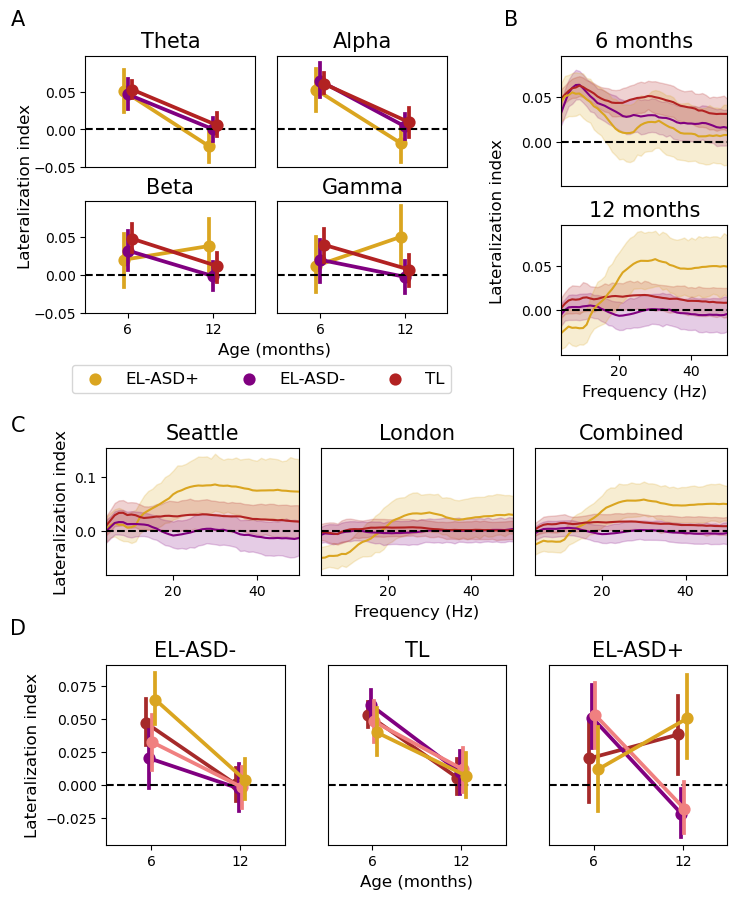

In [ ]:
fig = plt.figure(figsize=(7, 7), facecolor='white') #constrained_layout=False, 
gs1 = gridspec.GridSpec(2, 2, wspace=0)        
ax11 = fig.add_subplot(gs1[0, 0])

ax11.xaxis.set_visible(False)   
ax12 = fig.add_subplot(gs1[0, 1], sharex=ax11, sharey=ax11)
ax12.xaxis.set_visible(False)   
ax12.yaxis.set_visible(False)   


ax13 = fig.add_subplot(gs1[1, 0],sharex=ax11,sharey=ax11)
ax14 = fig.add_subplot(gs1[1, 1],sharex=ax11,sharey=ax11)
ax14.yaxis.set_visible(False)   

  
gs1.tight_layout(fig, rect=[-0.03, 0.56, 0.6, 1.02], w_pad=0.0, h_pad=1.2)

gs2 = gridspec.GridSpec(2, 1)        
ax21 = fig.add_subplot(gs2[0, 0])
ax22 = fig.add_subplot(gs2[1,0],sharex=ax21,sharey=ax21)
ax21.xaxis.set_visible(False)   

gs2.tight_layout(fig, rect=[0.65, 0.5, 1.0, 1.02], w_pad=0.0, h_pad=1.5)
gs3 = gridspec.GridSpec(1, 3)        
ax31 = fig.add_subplot(gs3[0, 0])
ax32 = fig.add_subplot(gs3[0, 1],sharex=ax31,sharey=ax31)
ax33 = fig.add_subplot(gs3[0, 2],sharex=ax31,sharey=ax31)
ax32.yaxis.set_visible(False)   
ax33.yaxis.set_visible(False)  
gs3.tight_layout(fig, rect=[0, 0.185, 1.0, 0.46], w_pad=0.0, h_pad=-0.5)

gs4 = gridspec.GridSpec(1, 3)        
ax41 = fig.add_subplot(gs4[0, 0])
ax42 = fig.add_subplot(gs4[0, 1],sharex=ax41,sharey=ax41)
ax43 = fig.add_subplot(gs4[0, 2],sharex=ax41,sharey=ax41)
gs4.tight_layout(fig, rect=[0, -0.2, 1.0, 0.15], w_pad=0.0, h_pad=-0.5)
ax42.yaxis.set_visible(False)   
ax43.yaxis.set_visible(False)  

fig.text(-0.055, 1.03, "A", size=BIGGER_SIZE, ha="center", transform=fig.transFigure)
fig.text(0.65, 1.03, "B", size=BIGGER_SIZE, ha="center", transform=fig.transFigure)
fig.text(-0.055, 0.45, "C", size=BIGGER_SIZE, ha="center", transform=fig.transFigure)
fig.text(-0.055, 0.16, "D", size=BIGGER_SIZE, ha="center", transform=fig.transFigure)

df_name=eeg_long2
df_name=df_name[~df_name.band.isna()]
df_name= df_name.loc[df_name.age<18]
df_name= df_name.loc[df_name.network=="all_regions"]
df_name.outcome= df_name.outcome.str.replace('HRA-', 'EL-ASD-', regex=True)
df_name.outcome= df_name.outcome.str.replace('control', 'TL', regex=True)
df_name.outcome= df_name.outcome.str.replace('asd', 'EL-ASD+', regex=True)
df_name=df_name.sort_values("outcome")
for ax, band in zip([ax11, ax12, ax13, ax14], ["Theta", "Alpha", "Beta","Gamma"]):
    sns.pointplot(x="age",y="l_index", hue="outcome",
              palette=["goldenrod","purple", "firebrick"],
              #palette=["goldenrod","purple", "lightcoral"],
              #palette=["goldenrod","purple", "lightcoral"],
                  
                  
                     data=df_name[df_name.band ==band.lower()],dodge=0.1, ax=ax)
    ax.set_title(band)
    ax.axhline(0,  linestyle='--', color="black")
    if band =="Beta":
        
        ax.legend(bbox_to_anchor=(-0.08, -0.72), loc="lower left", borderaxespad=0., ncol=3)
    else:
        ax.legend_.set_visible(False)            
ax11.set(ylabel="", xlabel="")
ax13.set(xlabel="")
ax13.set(ylabel="")
ax14.set(xlabel="")
"""ax13.set(xlabel="Age (months)")
ax13.set(ylabel="Lateralization index")
ax14.set(xlabel="Age (months)")"""
#ax11.legend("")
fig.text(0.23, 0.56, 'Age (months)', ha='left')
fig.text(-0.055, 0.8, 'Lateralization index', va='center', rotation='vertical')

graph_2_data = all_freq_df.groupby(["subject","outcome", "site","age","freq"]).mean().reset_index()
graph_2_data = graph_2_data.loc[graph_2_data.age!=18]
graph_2_data
both_sites= graph_2_data
both_sites["site"]="Combined"
graph_2_data = all_freq_df.groupby(["subject","outcome", "site","age","freq"]).mean().reset_index()
graph_2_data = graph_2_data.loc[graph_2_data.age!=18]
both_sites=pd.concat([graph_2_data,both_sites])
df_name=graph_2_data.copy()
df_name.outcome= df_name.outcome.str.replace('HRA-', 'EL-ASD-', regex=True)
df_name.outcome= df_name.outcome.str.replace('control', 'TL', regex=True)
df_name.outcome= df_name.outcome.str.replace('asd', 'EL-ASD+', regex=True)
for ax, age_n in zip([ax21, ax22], [6,12]):
    df2 = df_name.copy().loc[df_name.age==age_n]
    sns.lineplot(x="freq",y="l_index",hue="outcome", 
              palette=["purple","firebrick", "goldenrod"],
              #palette=["goldenrod","purple", "lightcoral"],
              #palette=["goldenrod","purple", "lightcoral"],
                 
              data=df2, ci=90,ax=ax )
    ax.axhline(0,  linestyle='--', color="black")
    ax.set_title(f"{age_n} months")
    ax.legend_.set_visible(False)   
    ax.set_xlim(all_freq_df.freq.unique()[[0,-1]])
ax21.set(ylabel="")
ax22.set(ylabel="")
ax22.set(xlabel="Frequency (Hz)")
fig.text(0.62, 0.75, 'Lateralization index', va='center', 
         rotation='vertical')
df_name=both_sites
df_name.outcome= df_name.outcome.str.replace('HRA-', 'EL-ASD-', regex=True)
df_name.outcome= df_name.outcome.str.replace('control', 'TL', regex=True)
df_name.outcome= df_name.outcome.str.replace('asd', 'EL-ASD+', regex=True)
df_name=df_name[df_name.age != 6]
df_name.site= df_name.site.str.replace('washington', 'Seattle', regex=True)
df_name.site= df_name.site.str.replace('london', 'London', regex=True)
df_name=df_name.sort_values("outcome")
for ax, place in zip([ax31, ax32, ax33], ["Seattle", "London","Combined"]):
    df2 = df_name.copy().loc[df_name.site==place]
    if place =="London":
        
        sns.lineplot(x="freq",y="l_index",hue="outcome", 
              palette=["goldenrod","purple", "firebrick"],
              #palette=["goldenrod","purple", "lightcoral"],
              #palette=["goldenrod","purple", "lightcoral"],


              data=df2, ci=90,ax=ax )
    
    else:
          sns.lineplot(x="freq",y="l_index",hue="outcome", 
             palette=["goldenrod","purple", "firebrick"],
              #palette=["goldenrod","purple", "lightcoral"],
              #palette=["goldenrod","purple", "lightcoral"],
            data=df2, ci=90,ax=ax )
        
    ax.legend_.set_visible(False)  
    ax.set_title(place)   
    ax.set_xlim(all_freq_df.freq.unique()[[0,-1]])
    ax.axhline(0,  linestyle='--', color="black")
ax31.set(ylabel="Lateralization index")
ax32.set(ylabel="")
ax33.set(ylabel="")
ax31.set(xlabel="")
ax32.set(xlabel="Frequency (Hz)")
ax33.set(xlabel="")

eeg_long3= eeg_long2[(eeg_long2.age!=18)]
#df_name= eeg_long3[(eeg_long3.band=="beta")]
df_name= eeg_long3
df_name["Band"]= df_name["band"]
df_name.Band = df_name.Band.str.capitalize()
df_name.outcome= df_name.outcome.str.replace('HRA-', 'EL-ASD-', regex=True)
df_name.outcome= df_name.outcome.str.replace('control', 'TL', regex=True)
df_name.outcome= df_name.outcome.str.replace('asd', 'EL-ASD+', regex=True)
df_name= df_name[(df_name.network=="all_regions")]
#sns.set_palette("colorblind")
df_name=df_name.sort_values("outcome")
for ax, group in zip([ax41, ax42, ax43], ["EL-ASD-", "TL","EL-ASD+"]):
    df2 = df_name.copy().loc[df_name.outcome==group]
    sns.pointplot(x="age",y="l_index",hue="Band",palette=["brown","purple", "lightcoral", "goldenrod"], 
                    data=df2, ci=90,ax=ax ,dodge=0.1 )
    ax.set_title(group)   
    ax.axhline(0,  linestyle='--', color="black")
    if group=="AR-ASD-":
 
        ax.legend(bbox_to_anchor=(0.3, -0.35), 
                 loc="upper left", borderaxespad=0., ncol=4)
    else:
        ax.legend_.set_visible(False) 
ax41.set(ylabel="Lateralization index")
ax42.set(ylabel="")
ax43.set(ylabel="")
ax41.set(xlabel="")
ax42.set(xlabel="Age (months)")
ax43.set(xlabel="")

fig.savefig("./Supp_figure_1_2023_01.png"  ,bbox_inches="tight",dpi=300)

## Supp Figure 2

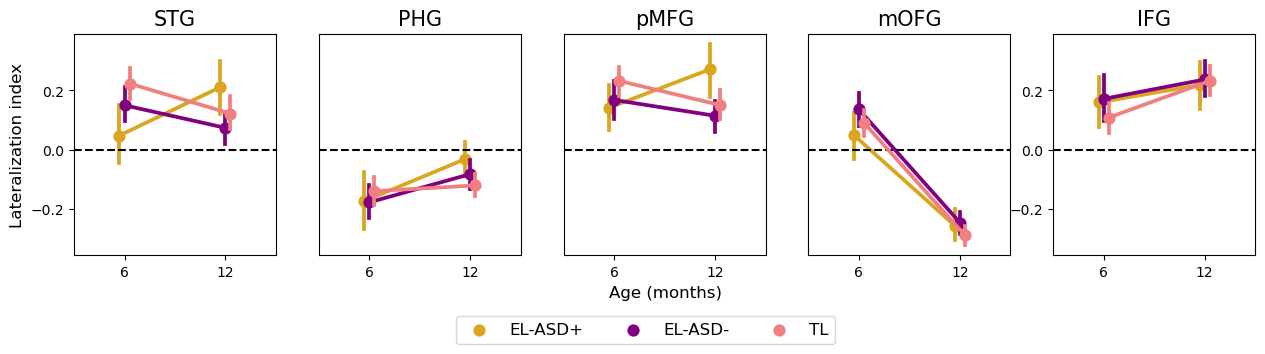

In [ ]:
fig = plt.figure(figsize=(9, 7), facecolor='white') #constrained_layout=False, 
gs1 = gridspec.GridSpec(1, 5)        
ax51 = fig.add_subplot(gs1[0, 0])
ax52 = fig.add_subplot(gs1[0, 1],sharex=ax51,sharey=ax51)
ax53 = fig.add_subplot(gs1[0, 2],sharex=ax51,sharey=ax51)
ax54 = fig.add_subplot(gs1[0, 3],sharex=ax51,sharey=ax51)
ax55 = fig.add_subplot(gs1[0, 4],sharex=ax51,sharey=ax51)

gs1.tight_layout(fig, rect=[0, 0.6, 1.4, 1.01], w_pad=0.0, h_pad=-0.5)
ax52.yaxis.set_visible(False)   
ax53.yaxis.set_visible(False) 
ax54.yaxis.set_visible(False) 



eeg_long3=eeg_long2.copy()
eeg_long3=eeg_long3.sort_values("site")

eeg_long3= eeg_long3[(eeg_long3.age!=18)]
eeg_long3= eeg_long3[(eeg_long3.band=="gamma")]
eeg_long3= eeg_long3.loc[(eeg_long3.network!="all_regions")]


df_name=eeg_long3
df_name.network= df_name.network.str.replace('all_regions', 'Across regions', regex=True)
df_name.network= df_name.network.str.replace('mfc', 'pMFG', regex=True)
df_name.network= df_name.network.str.replace('ofc', 'mOFG', regex=True)
df_name.network= df_name.network.str.replace('parsorbital', 'IFG', regex=True)
df_name.network= df_name.network.str.replace('auditory', 'STG', regex=True)
df_name.network= df_name.network.str.replace('parahippo', 'PHG', regex=True)

df_name.outcome= df_name.outcome.str.replace('HRA-', 'EL-ASD-', regex=True)
df_name.outcome= df_name.outcome.str.replace('control', 'TL', regex=True)
df_name.outcome= df_name.outcome.str.replace('asd', 'EL-ASD+', regex=True)
df_name=df_name.sort_values("outcome")

regions_order=['STG',"PHG",'pMFG',"mOFG" ,'IFG']
for ax, region in zip([ax51, ax52, ax53, ax54, ax55],regions_order):
    df2 = df_name.copy().loc[df_name.network==region]
    sns.pointplot(x="age",y="l_index",hue="outcome", 
                    data=df2, ci=90,ax=ax ,dodge=0.1,palette=["goldenrod","purple", "lightcoral"] )
    ax.set_title(region)   
    ax.axhline(0,  linestyle='--', color="black")
    if region=="STG":
        ax.legend(bbox_to_anchor=(1.89, -0.4), 
                 loc="lower left", borderaxespad=0., ncol=4)
        ax.set(ylabel="Lateralization index")
        ax.set(xlabel="")


    else:
        ax.legend_.set_visible(False)
        ax.set(ylabel="")
        ax.set(xlabel="")
fig.text(0.65, 0.6, 'Age (months)', ha='left')

fig.savefig("./Supp_Figure_2_2023_01.png"  ,bbox_inches="tight",dpi=300)